## Encoder-Decoder

### Encoder-Decoder architecture

The encoder-decoder architecture is a popular approach for image segmentation tasks. It consists of two main components:

1. **Encoder**: Responsible for capturing and encoding relevant features from the input image. Typically composed of convolutional and pooling layers that progressively reduce spatial dimensions.

2. **Decoder**: Responsible for generating the segmentation mask from the encoded features. Consists of upsampling/transposed convolutional layers that increase spatial dimensions. Often utilizes skip connections from the encoder to incorporate low-level spatial details.

This architecture allows the model to capture both high-level semantic information (from the encoder) and low-level spatial details (from the decoder skip connections), enabling accurate segmentation.

### Download Data

In [ ]:

!wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=1cfORNOh_p1KHbhw8U0zhGkjSC2IrGaTB&export=download&confirm=t&uuid=c5760839-02fd-436b-9e38-9635cd7d8aab&at=APZUnTVLTsvNxsW4SInOAOYrK9ZA%3A1715907782351' -O images.zip


--2024-10-22 19:03:18--  https://drive.usercontent.google.com/download?id=1cfORNOh_p1KHbhw8U0zhGkjSC2IrGaTB&export=download&confirm=t&uuid=c5760839-02fd-436b-9e38-9635cd7d8aab&at=APZUnTVLTsvNxsW4SInOAOYrK9ZA%3A1715907782351
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.164.97, 2607:f8b0:4005:80b::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.164.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 748584920 (714M) [application/octet-stream]
Saving to: ‘images.zip’

images.zip          100%[===================>] 713.91M  21.2MB/s    in 34s     

2024-10-22 19:03:54 (20.7 MB/s) - ‘images.zip’ saved [748584920/748584920]



In [2]:
!unzip images.zip

Archive:  images.zip
  inflating: kaggle_3m/README.md     
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif  
  inf

### Data Preprocessing

In [3]:
IMAGE_PATH = 'lgg-mri-segmentation/kaggle_3m'

In [4]:
## source: https://www.kaggle.com/code/saeedghamshadzai/image-segmentation-brain-tumor-u-net-cnn#Inferece
import os
paths = []

for dirname in os.listdir(IMAGE_PATH):
    if os.path.isdir(os.path.join(IMAGE_PATH, dirname)):

        for filename in os.listdir(os.path.join(IMAGE_PATH, dirname)):
            # Only the files with ',tif' format should be added to the 'paths' list
            if filename.endswith('.tif'):
                paths.append(IMAGE_PATH+'/'+dirname+'/'+filename)

len(paths), paths[:20:5]

(7858,
 ['lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif',
  'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif'])

In [6]:
## source https://www.kaggle.com/code/saeedghamshadzai/image-segmentation-brain-tumor-u-net-cnn#Inferece
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
def data_frame(data):
    # Storing only paths that don't end with 'mask.tiff'
    images = list(filter(lambda x: not x.endswith('mask.tif'), data))
    # Sorting images based on the number of each MRI.
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-1][:-4]))
    # Sorting by the patient IDs (each patient has more than 1 MRIs)
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))

    # Storing the image IDs
    IDs = list(map(lambda x: x.rsplit('/', 3)[-1][:-4], images))

    # Storing only paths that end with 'mask.tiff'
    masks = list(filter(lambda x: x.endswith('mask.tif'), data))
    # Sorting masks based on the number of each MRI.
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    # Sorting by the patient IDs (each patient has more than 1 MRIs)
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-3]))

    # Opens the images
    pixels = lambda x: Image.open(x)
    # Selects the largest pixel
    largest_pixel = lambda y: np.max(pixels(y))
    # Determines if the mask contains an abnormality or not (+ or -)
    # Remember that a negative image's mask is just an entirely black image.
    diagnotic_function = lambda z: 1 if largest_pixel(z) > 0 else 0
    # Storing the diagnosis corresponding to each image
    diagnoses = list(map(lambda x: diagnotic_function(x), masks))

    # Making the dataframe
    DataFrame = pd.DataFrame({'ID': IDs, 'Image': images, 'Mask': masks, 'Diagnosis': diagnoses})

    # Dividing the indexes into train, test, and validation
    train_index, test_index = train_test_split(DataFrame.index.values.tolist(), test_size=0.1, random_state=42)
    train_index, val_index = train_test_split(train_index, test_size=0.05, random_state=42)

    # Making train, test, and validation dataframes
    train_df, val_df, test_df = DataFrame.iloc[train_index], DataFrame.iloc[val_index], DataFrame.iloc[test_index]

    return train_df, val_df, test_df

# Making the dataframes
train_df, val_df, test_df = data_frame(paths)

print(len(train_df), len(val_df), len(test_df))

train_df.head()

3359 177 393


ID  \
3163  TCGA_FG_7637_20000922_31   
1462   TCGA_HT_7874_19950902_2   
3315  TCGA_EZ_7264_20010816_16   
2933  TCGA_HT_A61A_20000127_32   
297   TCGA_DU_6405_19851005_32   

                                                  Image  \
3163  lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20...   
1462  lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19...   
3315  lgg-mri-segmentation/kaggle_3m/TCGA_EZ_7264_20...   
2933  lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20...   
297   lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19...   

                                                   Mask  Diagnosis  
3163  lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20...          1  
1462  lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19...          0  
3315  lgg-mri-segmentation/kaggle_3m/TCGA_EZ_7264_20...          1  
2933  lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20...          1  
297   lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19...          0

### Visualizing

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

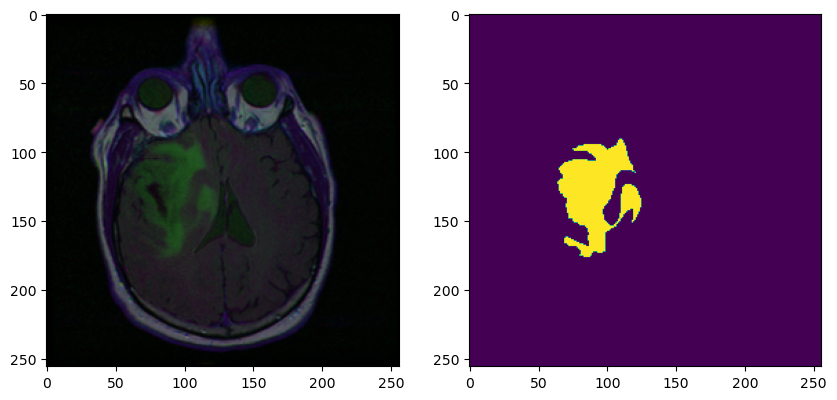

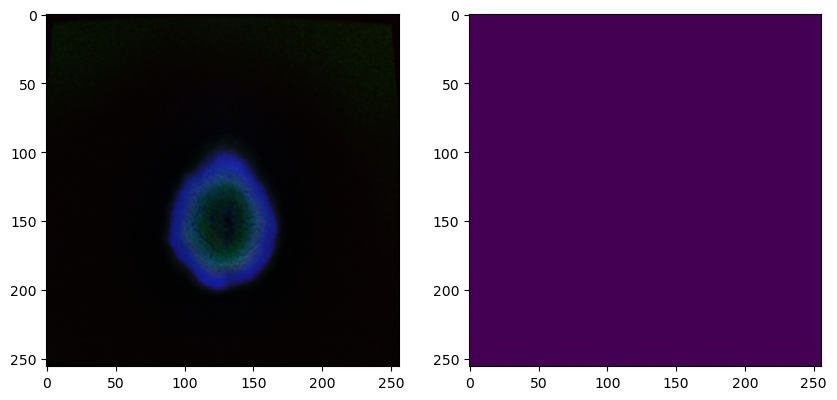

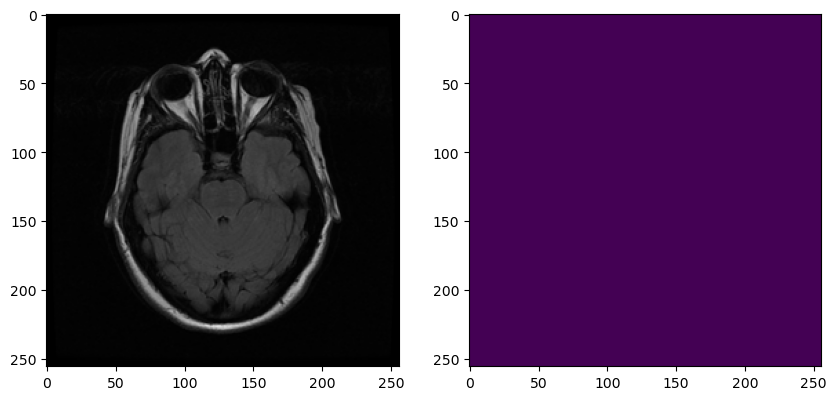

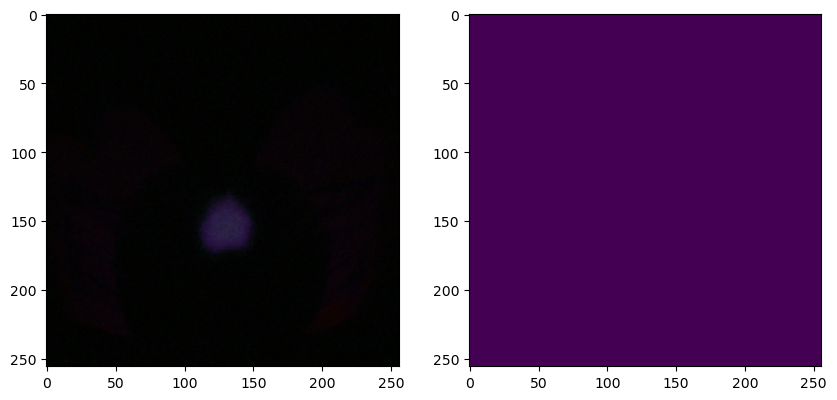

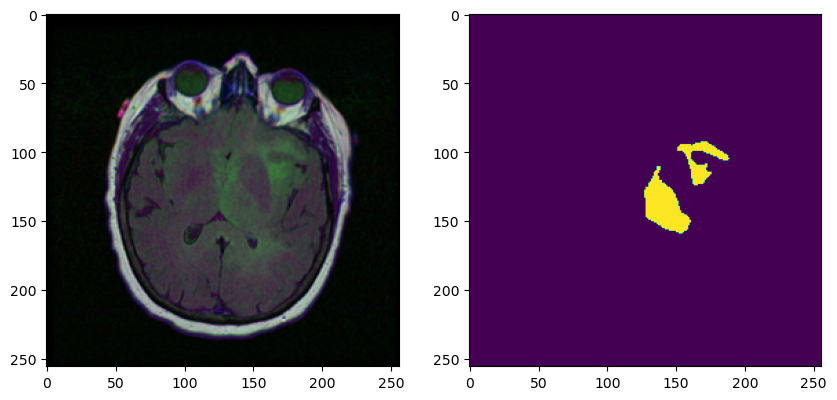

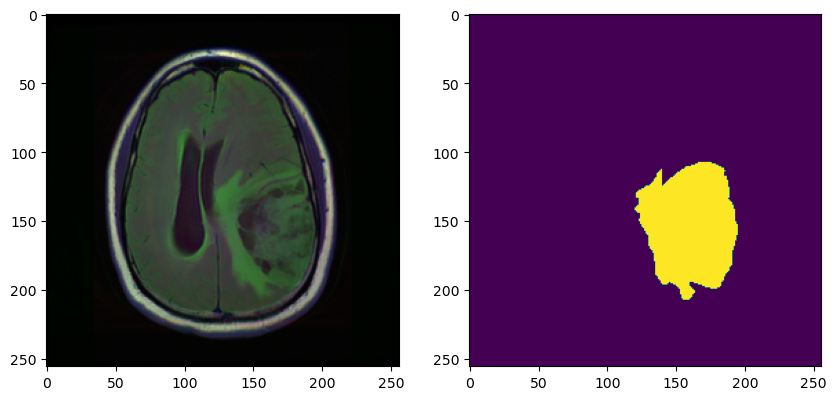

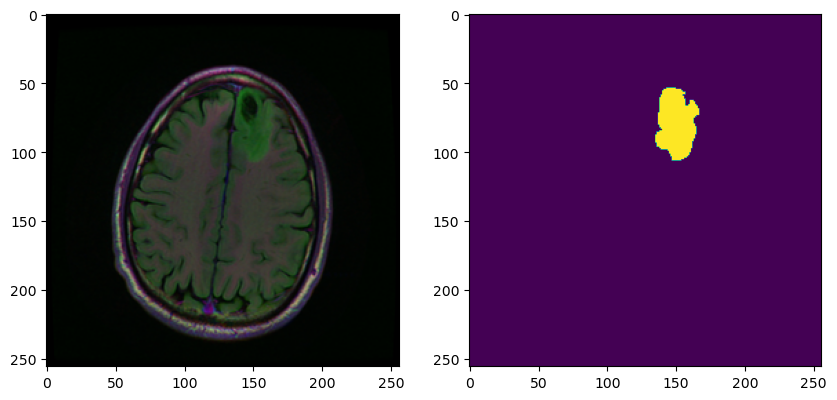

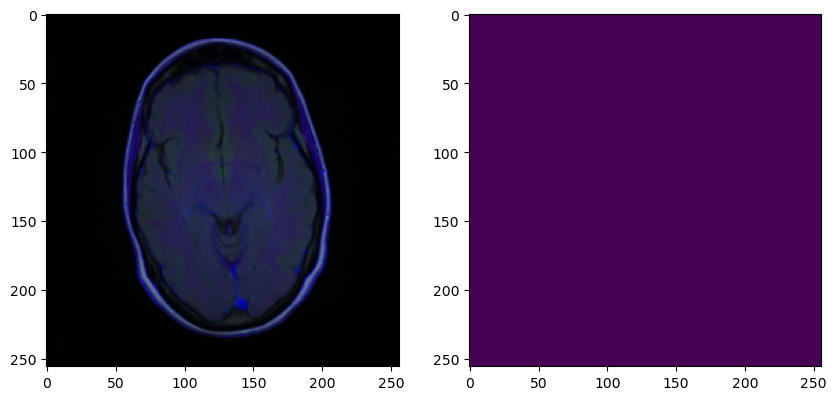

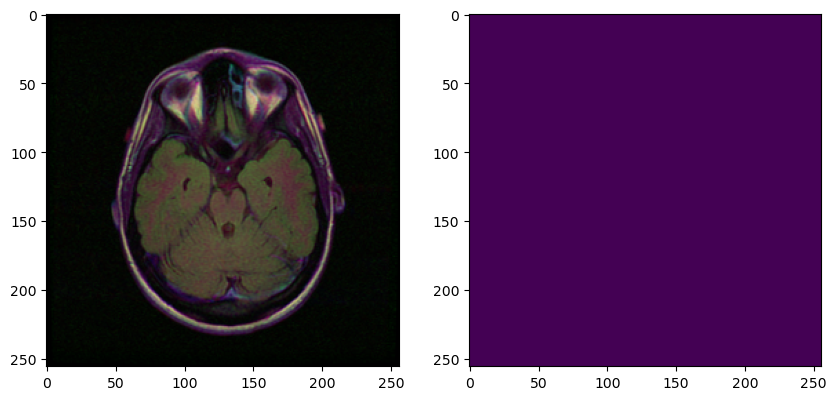

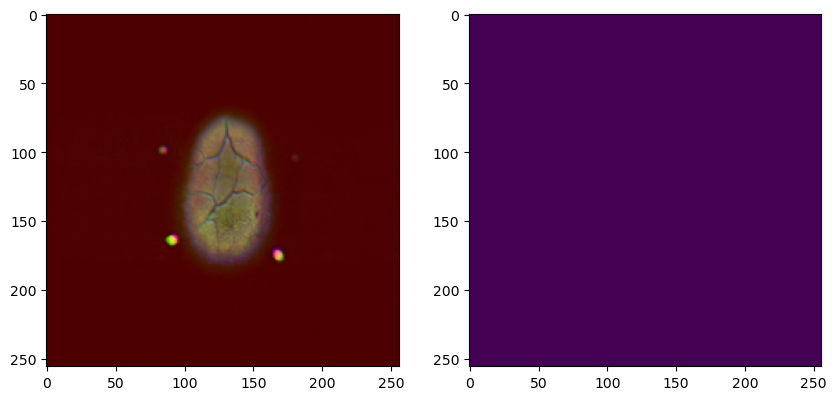

In [7]:
index = np.arange(train_df.shape[0])
rng = np.random.default_rng(37)
rng.shuffle(index)
for idx in range(10):
    image_path = train_df.iloc[index[idx]]['Image']
    mask_path = train_df.iloc[index[idx]]['Mask']
    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[1].imshow(mask)

### Training the Model

Encoder and Decoder model with BCELoss

In [8]:
import torch

print(torch.cuda.is_available())
if (torch.cuda.is_available()):
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.device_count())

True
NVIDIA GeForce RTX 2060
1


In [ ]:
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class EncoderDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderDecoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 128 x 128 x 64
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 64 x 64 x 128
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 32 x 32 x 256
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

device = torch.device(0 if torch.cuda.is_available() else 'cpu')
# Initialize the model
model = EncoderDecoder(3,1).float().to(device)




In [8]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        img = np.array(img)
        mask = np.array(mask)
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask


# Transform
transform = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.ToTensor()
])



NUM EPOCHS: 500
CANT FIND CHECKPOINT PATH


  0%|          | 0/500 [00:00<?, ?it/s]

CURRENT EPOCH TRAINING: 1
Epoch 1/500, Loss: 0.2943


  0%|          | 1/500 [01:58<16:29:20, 118.96s/it]

Dev Loss: 0.1405
CURRENT EPOCH TRAINING: 2
Epoch 2/500, Loss: 0.0330


  0%|          | 2/500 [03:55<16:15:24, 117.52s/it]

Dev Loss: 0.0263
CURRENT EPOCH TRAINING: 3
Epoch 3/500, Loss: 0.0256


  1%|          | 3/500 [05:53<16:14:17, 117.62s/it]

Dev Loss: 0.0242
CURRENT EPOCH TRAINING: 4
Epoch 4/500, Loss: 0.0245


  1%|          | 4/500 [07:50<16:09:44, 117.31s/it]

Dev Loss: 0.0233
CURRENT EPOCH TRAINING: 5
Epoch 5/500, Loss: 0.0241


  1%|          | 5/500 [09:46<16:04:31, 116.91s/it]

Dev Loss: 0.0233
CURRENT EPOCH TRAINING: 6
Epoch 6/500, Loss: 0.0232


  1%|          | 6/500 [11:42<16:01:03, 116.73s/it]

Dev Loss: 0.0235
CURRENT EPOCH TRAINING: 7
Epoch 7/500, Loss: 0.0217


  1%|▏         | 7/500 [13:39<15:58:53, 116.70s/it]

Dev Loss: 0.0210
CURRENT EPOCH TRAINING: 8
Epoch 8/500, Loss: 0.0212


  2%|▏         | 8/500 [15:36<15:57:32, 116.77s/it]

Dev Loss: 0.0208
CURRENT EPOCH TRAINING: 9
Epoch 9/500, Loss: 0.0201


  2%|▏         | 9/500 [17:34<16:00:07, 117.33s/it]

Dev Loss: 0.0206
CURRENT EPOCH TRAINING: 10
Epoch 10/500, Loss: 0.0199


  2%|▏         | 10/500 [19:32<16:00:04, 117.56s/it]

Dev Loss: 0.0191
CURRENT EPOCH TRAINING: 11
Epoch 11/500, Loss: 0.0190


  2%|▏         | 11/500 [21:31<16:00:08, 117.81s/it]

Dev Loss: 0.0181
CURRENT EPOCH TRAINING: 12
Epoch 12/500, Loss: 0.0192


  2%|▏         | 12/500 [23:28<15:58:03, 117.79s/it]

Dev Loss: 0.0177
CURRENT EPOCH TRAINING: 13
Epoch 13/500, Loss: 0.0184


  3%|▎         | 13/500 [25:26<15:55:23, 117.71s/it]

Dev Loss: 0.0167
CURRENT EPOCH TRAINING: 14
Epoch 14/500, Loss: 0.0182


  3%|▎         | 14/500 [27:25<15:55:45, 118.00s/it]

Dev Loss: 0.0162
CURRENT EPOCH TRAINING: 15
Epoch 15/500, Loss: 0.0172


  3%|▎         | 15/500 [29:21<15:50:28, 117.58s/it]

Dev Loss: 0.0160
CURRENT EPOCH TRAINING: 16
Epoch 16/500, Loss: 0.0161


  3%|▎         | 16/500 [31:18<15:46:46, 117.37s/it]

Dev Loss: 0.0163
CURRENT EPOCH TRAINING: 17
Epoch 17/500, Loss: 0.0161


  3%|▎         | 17/500 [33:16<15:46:53, 117.63s/it]

Dev Loss: 0.0156
CURRENT EPOCH TRAINING: 18
Epoch 18/500, Loss: 0.0158


  4%|▎         | 18/500 [35:13<15:42:48, 117.36s/it]

Dev Loss: 0.0162
CURRENT EPOCH TRAINING: 19
Epoch 19/500, Loss: 0.0155


  4%|▍         | 19/500 [37:09<15:36:45, 116.85s/it]

Dev Loss: 0.0149
CURRENT EPOCH TRAINING: 20
Epoch 20/500, Loss: 0.0147


  4%|▍         | 20/500 [39:04<15:30:34, 116.32s/it]

Dev Loss: 0.0148
CURRENT EPOCH TRAINING: 21
Epoch 21/500, Loss: 0.0150


  4%|▍         | 21/500 [41:03<15:34:46, 117.09s/it]

Dev Loss: 0.0138
CURRENT EPOCH TRAINING: 22
Epoch 22/500, Loss: 0.0144


  4%|▍         | 22/500 [42:58<15:27:50, 116.46s/it]

Dev Loss: 0.0132
CURRENT EPOCH TRAINING: 23
Epoch 23/500, Loss: 0.0145


  5%|▍         | 23/500 [44:55<15:28:58, 116.85s/it]

Dev Loss: 0.0142
CURRENT EPOCH TRAINING: 24
Epoch 24/500, Loss: 0.0134


  5%|▍         | 24/500 [46:54<15:30:00, 117.23s/it]

Dev Loss: 0.0130
CURRENT EPOCH TRAINING: 25
Epoch 25/500, Loss: 0.0134


  5%|▌         | 25/500 [48:51<15:28:11, 117.24s/it]

Dev Loss: 0.0129
CURRENT EPOCH TRAINING: 26
Epoch 26/500, Loss: 0.0131


  5%|▌         | 26/500 [50:49<15:28:12, 117.50s/it]

Dev Loss: 0.0136
CURRENT EPOCH TRAINING: 27
Epoch 27/500, Loss: 0.0127


  5%|▌         | 27/500 [52:48<15:30:32, 118.04s/it]

Dev Loss: 0.0151
CURRENT EPOCH TRAINING: 28
Epoch 28/500, Loss: 0.0124


  6%|▌         | 28/500 [54:46<15:27:26, 117.90s/it]

Dev Loss: 0.0122
CURRENT EPOCH TRAINING: 29
Epoch 29/500, Loss: 0.0118


  6%|▌         | 29/500 [56:44<15:25:01, 117.84s/it]

Dev Loss: 0.0116
CURRENT EPOCH TRAINING: 30
Epoch 30/500, Loss: 0.0115


  6%|▌         | 30/500 [58:40<15:19:44, 117.41s/it]

Dev Loss: 0.0135
CURRENT EPOCH TRAINING: 31
Epoch 31/500, Loss: 0.0110


  6%|▌         | 31/500 [1:00:37<15:16:04, 117.19s/it]

Dev Loss: 0.0109
CURRENT EPOCH TRAINING: 32
Epoch 32/500, Loss: 0.0109


  6%|▋         | 32/500 [1:02:34<15:13:26, 117.11s/it]

Dev Loss: 0.0109
CURRENT EPOCH TRAINING: 33
Epoch 33/500, Loss: 0.0108


  7%|▋         | 33/500 [1:04:30<15:10:49, 117.02s/it]

Dev Loss: 0.0108
CURRENT EPOCH TRAINING: 34
Epoch 34/500, Loss: 0.0105


  7%|▋         | 34/500 [1:06:28<15:09:42, 117.13s/it]

Dev Loss: 0.0116
CURRENT EPOCH TRAINING: 35
Epoch 35/500, Loss: 0.0097


  7%|▋         | 35/500 [1:08:25<15:07:45, 117.13s/it]

Dev Loss: 0.0110
CURRENT EPOCH TRAINING: 36
Epoch 36/500, Loss: 0.0101


  7%|▋         | 36/500 [1:10:24<15:09:41, 117.63s/it]

Dev Loss: 0.0103
CURRENT EPOCH TRAINING: 37
Epoch 37/500, Loss: 0.0095


  7%|▋         | 37/500 [1:12:20<15:03:55, 117.14s/it]

Dev Loss: 0.0097
CURRENT EPOCH TRAINING: 38
Epoch 38/500, Loss: 0.0097


  8%|▊         | 38/500 [1:14:17<15:01:57, 117.14s/it]

Dev Loss: 0.0097
CURRENT EPOCH TRAINING: 39
Epoch 39/500, Loss: 0.0092


  8%|▊         | 39/500 [1:16:16<15:04:14, 117.69s/it]

Dev Loss: 0.0096
CURRENT EPOCH TRAINING: 40
Epoch 40/500, Loss: 0.0092


  8%|▊         | 40/500 [1:18:14<15:03:35, 117.86s/it]

Dev Loss: 0.0095
CURRENT EPOCH TRAINING: 41
Epoch 41/500, Loss: 0.0088


  8%|▊         | 41/500 [1:20:12<15:00:47, 117.75s/it]

Dev Loss: 0.0105
CURRENT EPOCH TRAINING: 42
Epoch 42/500, Loss: 0.0086


  8%|▊         | 42/500 [1:22:11<15:03:06, 118.31s/it]

Dev Loss: 0.0093
CURRENT EPOCH TRAINING: 43
Epoch 43/500, Loss: 0.0084


  9%|▊         | 43/500 [1:24:10<15:02:08, 118.44s/it]

Dev Loss: 0.0109
CURRENT EPOCH TRAINING: 44
Epoch 44/500, Loss: 0.0086


  9%|▉         | 44/500 [1:26:08<14:59:21, 118.34s/it]

Dev Loss: 0.0106
CURRENT EPOCH TRAINING: 45
Epoch 45/500, Loss: 0.0077


  9%|▉         | 45/500 [1:28:07<14:59:07, 118.57s/it]

Dev Loss: 0.0092
CURRENT EPOCH TRAINING: 46
Epoch 46/500, Loss: 0.0073


  9%|▉         | 46/500 [1:30:05<14:54:45, 118.25s/it]

Dev Loss: 0.0112
CURRENT EPOCH TRAINING: 47
Epoch 47/500, Loss: 0.0081


  9%|▉         | 47/500 [1:32:03<14:53:31, 118.35s/it]

Dev Loss: 0.0098
CURRENT EPOCH TRAINING: 48
Epoch 48/500, Loss: 0.0079


 10%|▉         | 48/500 [1:34:02<14:52:02, 118.41s/it]

Dev Loss: 0.0091
CURRENT EPOCH TRAINING: 49
Epoch 49/500, Loss: 0.0071


 10%|▉         | 49/500 [1:36:00<14:49:57, 118.40s/it]

Dev Loss: 0.0099
CURRENT EPOCH TRAINING: 50
Epoch 50/500, Loss: 0.0069


 10%|█         | 50/500 [1:37:58<14:47:33, 118.34s/it]

Dev Loss: 0.0092
CURRENT EPOCH TRAINING: 51
Epoch 51/500, Loss: 0.0067


 10%|█         | 51/500 [1:39:57<14:45:37, 118.35s/it]

Dev Loss: 0.0104
CURRENT EPOCH TRAINING: 52
Epoch 52/500, Loss: 0.0067


 10%|█         | 52/500 [1:41:55<14:43:21, 118.31s/it]

Dev Loss: 0.0093
CURRENT EPOCH TRAINING: 53
Epoch 53/500, Loss: 0.0066


 11%|█         | 53/500 [1:43:52<14:39:15, 118.02s/it]

Dev Loss: 0.0093
CURRENT EPOCH TRAINING: 54
Epoch 54/500, Loss: 0.0066


 11%|█         | 54/500 [1:45:50<14:36:08, 117.87s/it]

Dev Loss: 0.0093
CURRENT EPOCH TRAINING: 55
Epoch 55/500, Loss: 0.0063


 11%|█         | 55/500 [1:47:47<14:32:49, 117.68s/it]

Dev Loss: 0.0087
CURRENT EPOCH TRAINING: 56
Epoch 56/500, Loss: 0.0059


 11%|█         | 56/500 [1:49:45<14:31:28, 117.77s/it]

Dev Loss: 0.0091
CURRENT EPOCH TRAINING: 57
Epoch 57/500, Loss: 0.0063


 11%|█▏        | 57/500 [1:51:44<14:32:41, 118.20s/it]

Dev Loss: 0.0088
CURRENT EPOCH TRAINING: 58
Epoch 58/500, Loss: 0.0058


 12%|█▏        | 58/500 [1:53:43<14:32:14, 118.40s/it]

Dev Loss: 0.0092
CURRENT EPOCH TRAINING: 59
Epoch 59/500, Loss: 0.0057


 12%|█▏        | 59/500 [1:55:42<14:30:54, 118.49s/it]

Dev Loss: 0.0095
CURRENT EPOCH TRAINING: 60
Epoch 60/500, Loss: 0.0057


 12%|█▏        | 60/500 [1:57:38<14:24:54, 117.94s/it]

Dev Loss: 0.0105
CURRENT EPOCH TRAINING: 61
Epoch 61/500, Loss: 0.0058


 12%|█▏        | 61/500 [1:59:37<14:25:15, 118.26s/it]

Dev Loss: 0.0089
CURRENT EPOCH TRAINING: 62
Epoch 62/500, Loss: 0.0056


 12%|█▏        | 62/500 [2:01:36<14:23:58, 118.35s/it]

Dev Loss: 0.0109
CURRENT EPOCH TRAINING: 63
Epoch 63/500, Loss: 0.0053


 13%|█▎        | 63/500 [2:03:33<14:19:02, 117.95s/it]

Dev Loss: 0.0088
CURRENT EPOCH TRAINING: 64
Epoch 64/500, Loss: 0.0056


 13%|█▎        | 64/500 [2:05:30<14:15:49, 117.77s/it]

Dev Loss: 0.0102
CURRENT EPOCH TRAINING: 65
Epoch 65/500, Loss: 0.0051


 13%|█▎        | 65/500 [2:07:29<14:16:43, 118.17s/it]

Dev Loss: 0.0091
CURRENT EPOCH TRAINING: 66
Epoch 66/500, Loss: 0.0047


 13%|█▎        | 66/500 [2:09:27<14:14:18, 118.11s/it]

Dev Loss: 0.0118
CURRENT EPOCH TRAINING: 67
Epoch 67/500, Loss: 0.0046


 13%|█▎        | 67/500 [2:11:26<14:12:20, 118.11s/it]

Dev Loss: 0.0112
CURRENT EPOCH TRAINING: 68
Epoch 68/500, Loss: 0.0045


 14%|█▎        | 68/500 [2:13:23<14:08:49, 117.89s/it]

Dev Loss: 0.0097
CURRENT EPOCH TRAINING: 69
Epoch 69/500, Loss: 0.0048


 14%|█▍        | 69/500 [2:15:25<14:15:28, 119.09s/it]

Dev Loss: 0.0110
CURRENT EPOCH TRAINING: 70
Epoch 70/500, Loss: 0.0047


 14%|█▍        | 69/500 [2:17:21<14:17:59, 119.44s/it]


Dev Loss: 0.0095
Early stopping after 70 epochs.


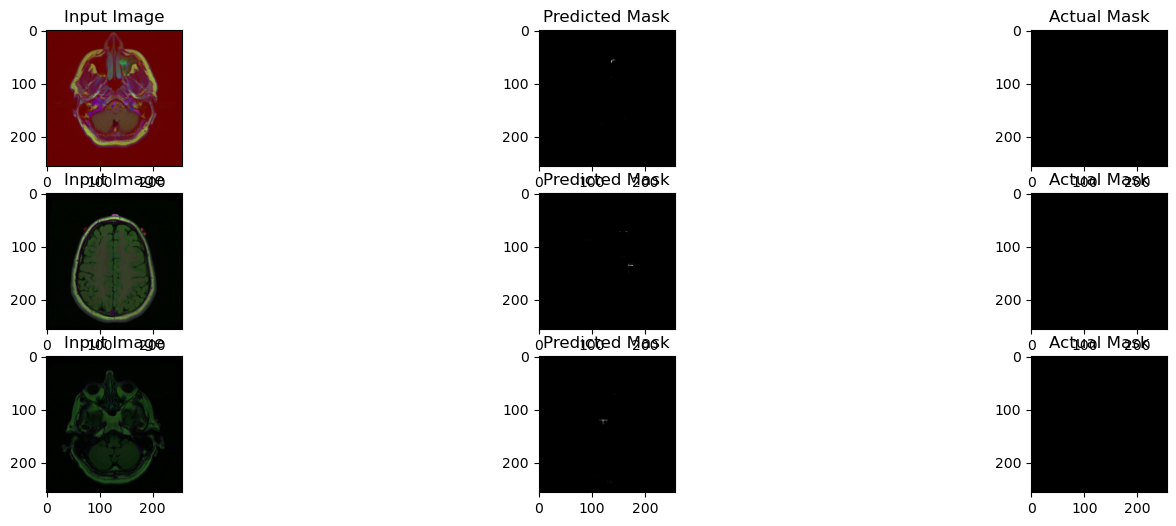

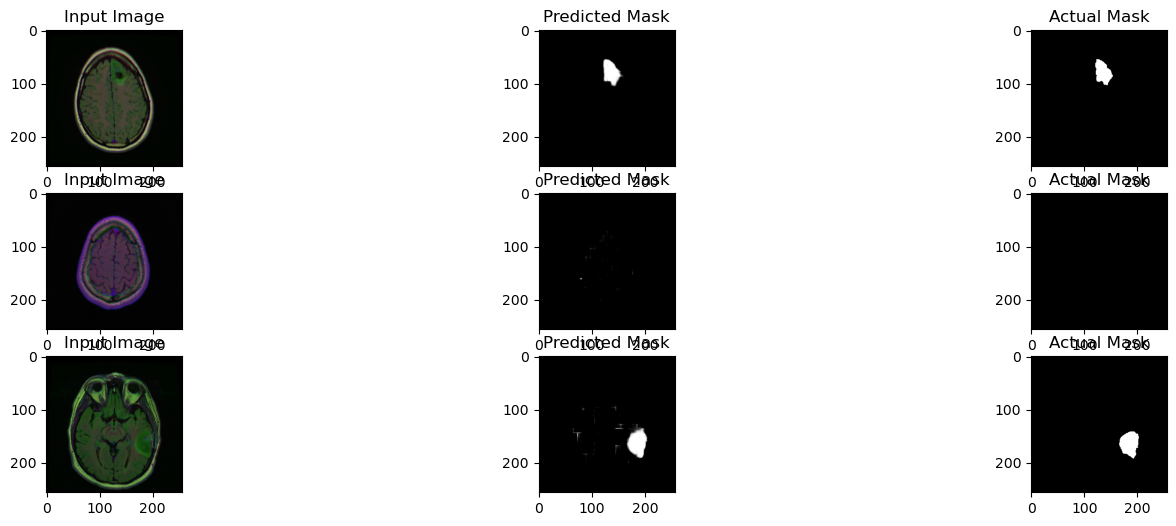

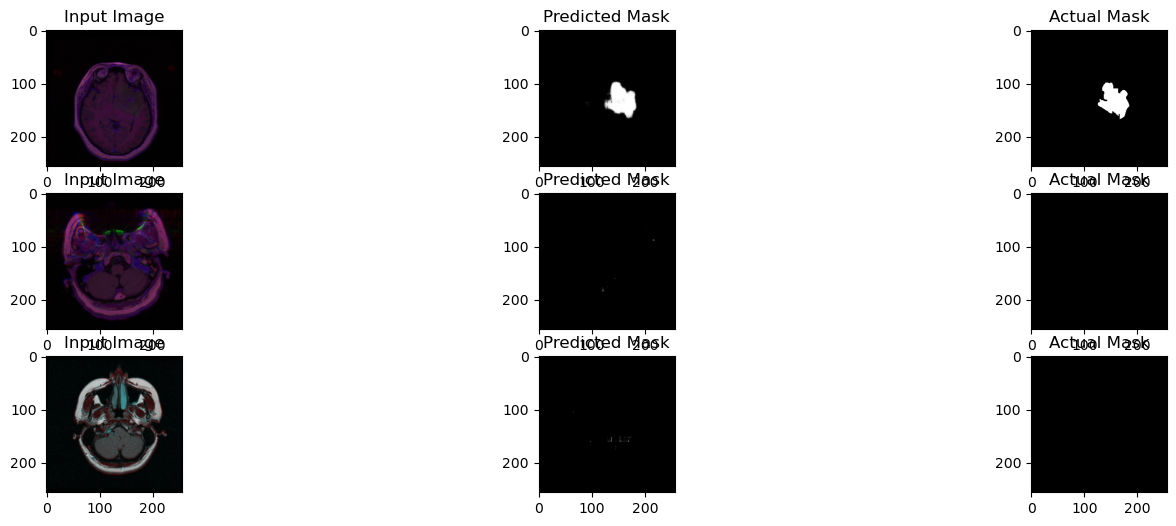

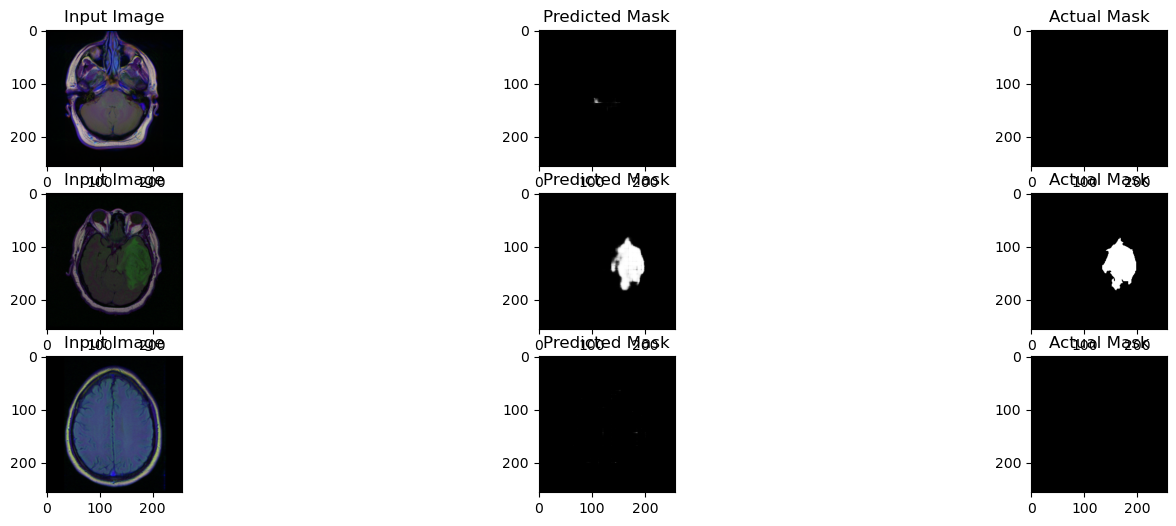

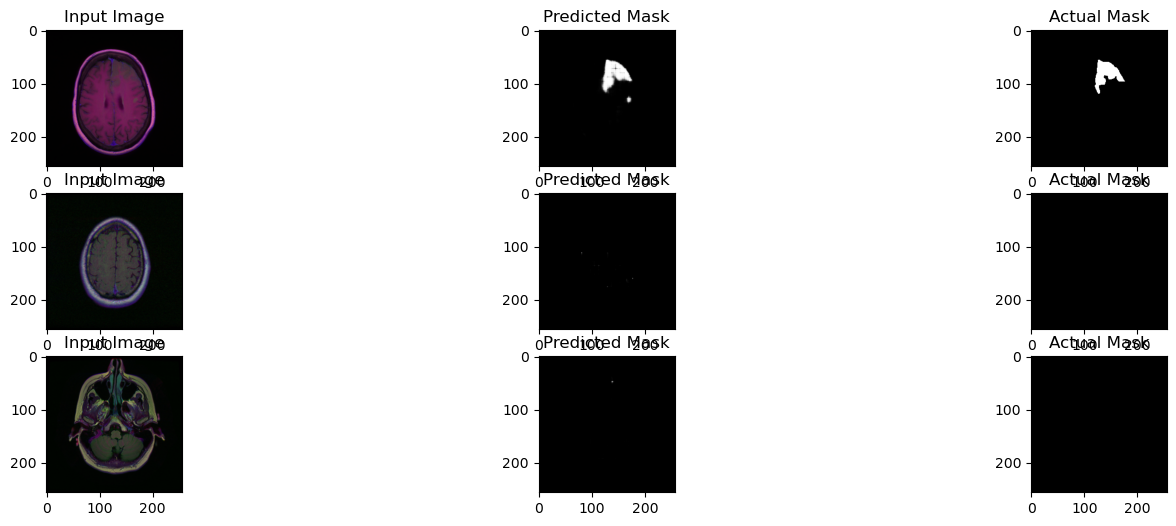

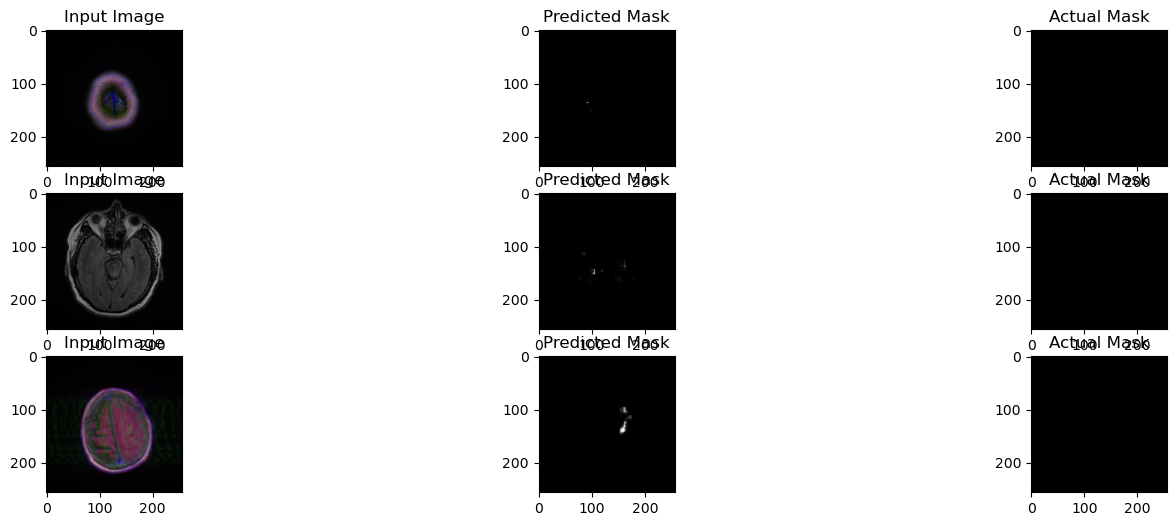

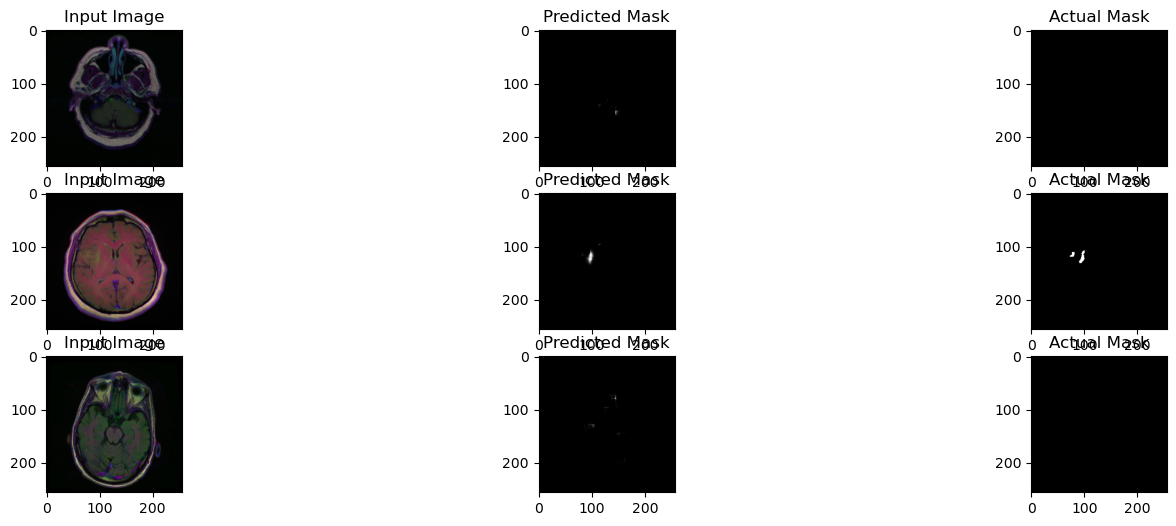

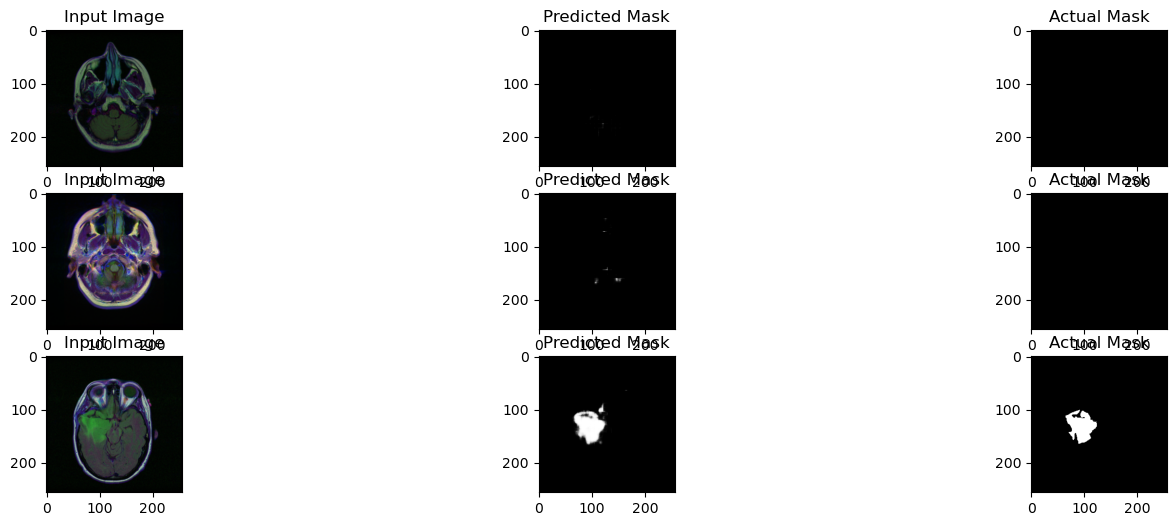

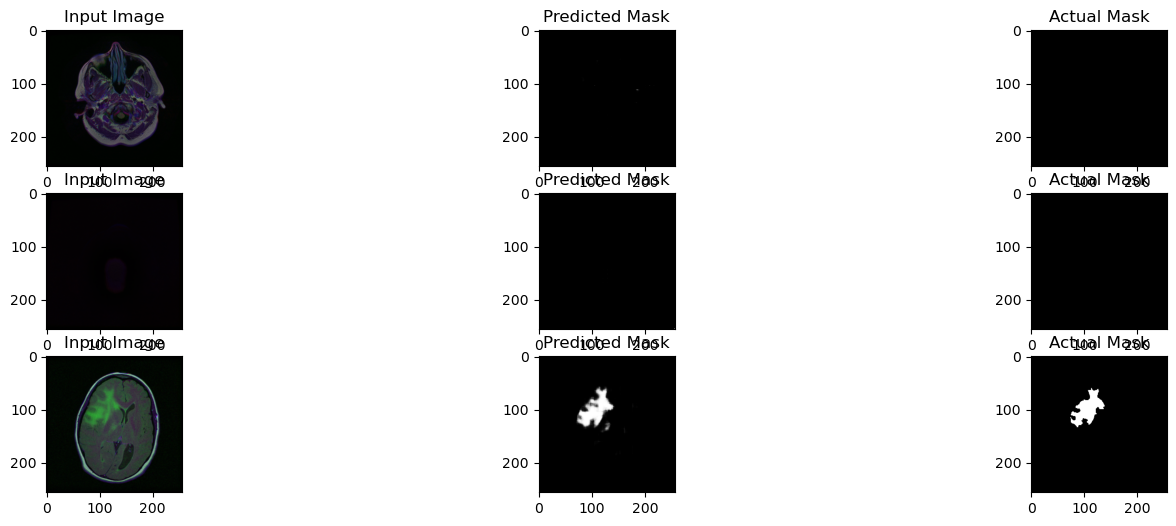

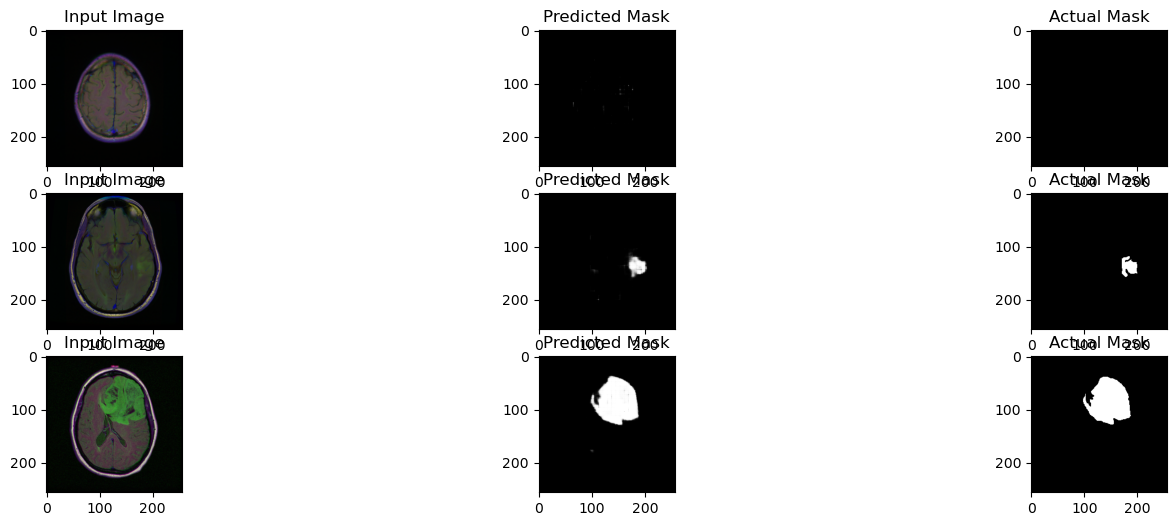

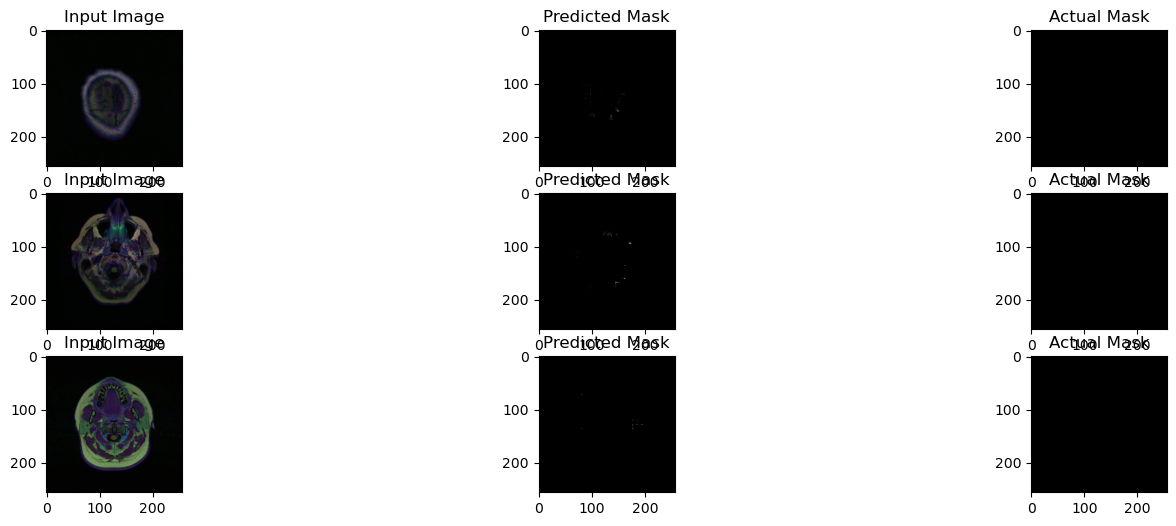

In [9]:
from tqdm import tqdm
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Training loop
def train(model, dataloader, dev_dataloader, criterion, optimizer, num_epochs=500, patience=15):
    model.train()
    best_dev_loss = np.inf
    early_stopping_counter = 0
    patience = patience
    print(f"NUM EPOCHS: {num_epochs}")
    # Load previous checkpoint if needed (optional)
    checkpoint_path = 'latest_checkpoint.pth'
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        print("Resuming training from checkpoint...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_dev_loss = checkpoint['best_dev_loss']
        print(f"CURRENT EPOCH FROM LAST CHECKPOINT: {checkpoint['epoch']}")
    else:
        print("CANT FIND CHECKPOINT PATH")

    # Main training loop
    for epoch in tqdm(range(start_epoch, num_epochs)):
        print(f"CURRENT EPOCH TRAINING: {epoch+1}")
        running_loss = 0.0
        for images, masks in dataloader:
            # Move tensors to the appropriate device
            images = images.float().to(device)
            masks = masks.float().to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        # Validation loop
        model.eval()
        dev_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(dev_dataloader, desc='Evaluating on dev set', unit='batch'):
                images = images.float().to(device)
                masks = masks.float().to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                dev_loss += loss.item() * images.size(0)

        dev_loss = dev_loss / len(dev_dataloader.dataset)
        print(f'Dev Loss: {dev_loss:.4f}')

        # Save checkpoints every 2 epochs
        if (epoch+1) % 2 == 0:
            #print("INSIDE CHECKPOINT SAVER")
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_dev_loss': best_dev_loss,
            }
            torch.save(checkpoint, 'latest_checkpoint.pth')

        # Save the best model based on validation loss
        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Early stopping after {epoch+1} epochs.')
                torch.save(model.state_dict(), 'final_model.pth')
                break
        # Save a checkpoint after each epoch

def evaluate(model, dataloader):
    model.eval()
    with torch.no_grad():
        counter = 0
        for images, masks in dataloader:
            if counter > 10:
                break
            counter += 1
            # Move tensors to the appropriate device
            images = images.float().to(device)
            masks = masks.float().to(device)

            # Forward pass
            outputs = model(images)

            # Plot the results for visualization
            plt.figure(figsize=(18, 6))
            for i in range(min(len(images), 3)):
                plt.subplot(3, 3, i*3 + 1)
                plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))
                plt.title('Input Image')

                plt.subplot(3, 3, i*3 + 2)
                plt.imshow(outputs[i].cpu().numpy().squeeze(), cmap='gray')
                plt.title('Predicted Mask')

                plt.subplot(3, 3, i*3 + 3)
                plt.imshow(masks[i].cpu().numpy().squeeze(), cmap='gray')
                plt.title('Actual Mask')

            plt.show()


image_paths = train_df['Image'].values.tolist()
mask_paths = train_df['Mask'].values.tolist()

dev_paths = val_df['Image'].values.tolist()
dev_mask_paths = val_df['Mask'].values.tolist()
dataset = SegmentationDataset(image_paths, mask_paths, transform=transform)
dev_dataset = SegmentationDataset(dev_paths, dev_mask_paths, transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
# Training
train(model, dataloader, dev_dataloader, criterion, optimizer, num_epochs=500)

# Evaluation
evaluate(model, dataloader)


### Evaluating the performance

This section evaluates our model's segmentation performance using two common metrics: Intersection over Union (IoU) and Dice coefficient (Dice). Both metrics quantify the overlap between predicted and ground truth segmentation masks.

IoU focuses on the ratio of correctly classified pixels, while Dice emphasizes the balance between true positives and both false positives and negatives. We'll calculate these scores to assess the model's segmentation accuracy.

In [10]:
import torch

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    return iou

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = torch.sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (torch.sum(y_true) + torch.sum(y_pred) + smooth)
    #print(dice)
    return dice


In [11]:
def eval_model(model, test_loader, device):
    model.eval()
    ious = []
    dices = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.float().to(device)
            masks = masks.float().to(device)
            outputs = model(images)
            
            outputs[outputs < .5] = 0
            outputs[outputs > .5] = 1

            iou_score_val = iou_score(outputs, masks)
            dice_score_val = dice_score(outputs, masks)

            ious.append(iou_score_val)
            dices.append(dice_score_val)

    mean_iou = sum(ious) / len(ious)
    mean_dice = sum(dices) / len(dices)

    return mean_iou, mean_dice

In [12]:
test_dataset = SegmentationDataset(test_df[test_df['Diagnosis'] == 1]['Image'].values.tolist(), test_df[test_df['Diagnosis'] == 1]['Mask'].values.tolist(), transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
eval_model(model, test_dataloader, device)

(tensor(0.7560, device='cuda:0'), tensor(0.8609, device='cuda:0'))

In [13]:
torch.save(model.state_dict(), 'final_model.pth')

In [14]:
model.load_state_dict(torch.load('final_model.pth'))

<All keys matched successfully>